# Python notebook to generate a zero-offset synthetic from a 3-layer wedge model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import wedge_utils as wu

### 3-Layer Model Parameters [Layer 1, Layer 2, Layer 3]

In [2]:
vp_mod = [2500.0, 2600.0, 2550.0]  # P-wave velocity (m/s)
vs_mod = [1200.0, 1300.0, 1200.0]  # S-wave velocity (m/s)
rho_mod= [1.95, 2.0, 1.98]         # Density (g/cc)

dz_min = 0.0   # Minimum thickness of Layer 2 (m)
dz_max = 60.0  # Maximum thickness of Layer 2 (m)
dz_step= 1.0   # Thickness step from trace-to-trace (normally 1.0 m)

### Wavelet Parameters

In [3]:
wvlt_type = 'ricker'  # Valid values: 'ricker' or 'bandpass'
wvlt_length= 0.128 # Wavelet length in seconds
wvlt_phase = 0.0   # Wavelet phase in degrees
wvlt_scalar = 1.0  # Multiplier to scale wavelet amplitude (default = 1.0)
wvlt_cfreq = 30.0  # Ricker wavelet central frequency
f1 =  5.0          # Bandpass wavelet low truncation frequency
f2 = 10.0          # Bandpass wavelet low cut frequency
f3 = 50.0          # Bandpass wavelet high cut frequency
f4 = 65.0          # Bandpass wavelet high truncation frequency

### Trace Parameters

In [4]:
tmin = 0.0
tmax = 0.5
dt = 0.0001 # changing this from 0.0001 can affect the display quality

### Plot Parameters

In [5]:
min_plot_time = 0.15
max_plot_time = 0.3
excursion = 2

### Some handy constants

In [6]:
nlayers = len(vp_mod)
nint = nlayers - 1
nmodel = int((dz_max-dz_min)/dz_step+1)

### Generate Wavelet

In [7]:
if wvlt_type == 'ricker':
    wvlt_t, wvlt_amp = wu.ricker(wvlt_cfreq, wvlt_phase, dt, wvlt_length)
    
elif wvlt_type == 'bandpass':
    wvlt_t, wvlt_amp = wu.wvlt_bpass(f1, f2, f3, f4, wvlt_phase, dt, wvlt_length)

### Apply amplitude scale factor to wavelet (to match seismic amplitude values)

In [8]:
wvlt_amp = wvlt_scalar * wvlt_amp

### Calculate reflectivities from model parameters

In [9]:
rc_int = wu.calc_rc(vp_mod, rho_mod)


syn_zo = []
rc_zo = []
lyr_times = []
for model in range(0, nmodel):
    
    #   Calculate interface depths
    z_int = [500.0]
    z_int.append(z_int[0]+dz_min+dz_step*model)
    
    #   Calculate interface times
    t_int = wu.calc_times(z_int, vp_mod)
    lyr_times.append(t_int)
    
    #   Digitize 3-layer model
    nsamp = int((tmax-tmin)/dt) + 1
    t = []
    for i in range(0,nsamp):
        t.append(i*dt)
        
    rc = wu.digitize_model(rc_int, t_int, t)
    rc_zo.append(rc)
    
    #   Convolve wavelet with reflectivities
    syn_buf = np.convolve(rc, wvlt_amp, mode='same')
    syn_buf = list(syn_buf)
    syn_zo.append(syn_buf)
    print ("finished step %i" % (model))
    
syn_zo = np.array(syn_zo)
t = np.array(t)
lyr_times = np.array(lyr_times)
lyr_indx = np.array(np.round(lyr_times/dt), dtype='int16')

# Use the transpose because rows are traces;
# columns are time samples.
tuning_trace = np.argmax(np.abs(syn_zo.T)) % syn_zo.T.shape[1]
tuning_thickness = tuning_trace * dz_step

finished step 0
finished step 1
finished step 2
finished step 3
finished step 4
finished step 5
finished step 6
finished step 7
finished step 8
finished step 9
finished step 10
finished step 11
finished step 12
finished step 13
finished step 14
finished step 15
finished step 16
finished step 17
finished step 18
finished step 19
finished step 20
finished step 21
finished step 22
finished step 23
finished step 24
finished step 25
finished step 26
finished step 27
finished step 28
finished step 29
finished step 30
finished step 31
finished step 32
finished step 33
finished step 34
finished step 35
finished step 36
finished step 37
finished step 38
finished step 39
finished step 40
finished step 41
finished step 42
finished step 43
finished step 44
finished step 45
finished step 46
finished step 47
finished step 48
finished step 49
finished step 50
finished step 51
finished step 52
finished step 53
finished step 54
finished step 55
finished step 56
finished step 57
finished step 58
finishe

### Plot the result

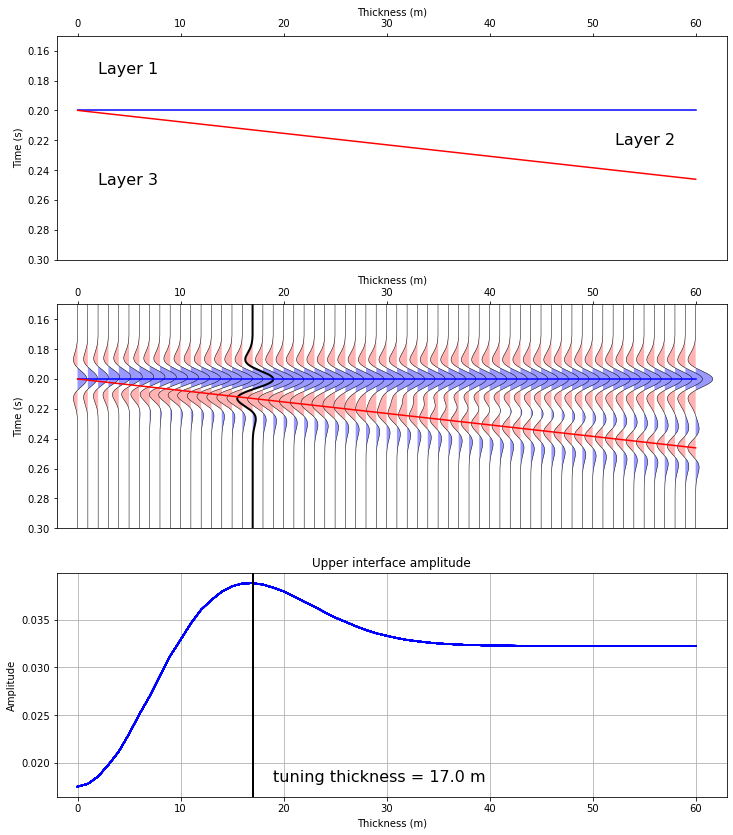

In [10]:
[ntrc, nsamp] = syn_zo.shape

fig = plt.figure(figsize=(12, 14))
fig.set_facecolor('white')

gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])

ax0 = fig.add_subplot(gs[0])
ax0.plot(lyr_times[:,0], color='blue', lw=1.5)
ax0.plot(lyr_times[:,1], color='red', lw=1.5)
ax0.set_ylim((min_plot_time,max_plot_time))
ax0.invert_yaxis()
ax0.set_xlabel('Thickness (m)')
ax0.set_ylabel('Time (s)')
plt.text(2,
        min_plot_time + (lyr_times[0,0] - min_plot_time)/2.,
        'Layer 1',
        fontsize=16)
plt.text(dz_max/dz_step - 2,
        lyr_times[-1,0] + (lyr_times[-1,1] - lyr_times[-1,0])/2.,
        'Layer 2',
        fontsize=16,
        horizontalalignment='right')
plt.text(2,
        lyr_times[0,0] + (max_plot_time - lyr_times[0,0])/2.,
        'Layer 3',
        fontsize=16)
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
ax0.set_xlim((-excursion, ntrc+excursion))

ax1 = fig.add_subplot(gs[1])
wu.plot_vawig(ax1, syn_zo, t, excursion, highlight=tuning_trace)
ax1.plot(lyr_times[:,0], color='blue', lw=1.5)
ax1.plot(lyr_times[:,1], color='red', lw=1.5)
ax1.set_ylim((min_plot_time,max_plot_time))
ax1.invert_yaxis()
ax1.set_xlabel('Thickness (m)')
ax1.set_ylabel('Time (s)')

ax2 = fig.add_subplot(gs[2])
ax2.plot(syn_zo[:,lyr_indx[:,0]], color='blue')
ax2.set_xlim((-excursion, ntrc+excursion))
ax2.axvline(tuning_trace, color='k', lw=2)
ax2.grid()
ax2.set_title('Upper interface amplitude')
ax2.set_xlabel('Thickness (m)')
ax2.set_ylabel('Amplitude')
plt.text(tuning_trace + 2,
        plt.ylim()[0] * 1.1,
        'tuning thickness = {0} m'.format(str(tuning_thickness)),
        fontsize=16)

plt.savefig('figure_1.png')
plt.show()